# Sentiment on Economic Debt in Zambia Using GDELT Data

The aim of this analysis is to answer the following questions using GDELT Global Knowledge Graph Data.

1. What has been the sentiment change in Zambia towards economic debt in the past year?
2. Has the change in president changed the sentiment on economic debt? Is there a clear difference in tone when we compare mentions for the two presidents?

Use Cases for this analysis:
1. The analysis can be used as a signal for risk forecasting models that predict yield on the international bond markets

In [209]:
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import pyLDAvis
import pyLDAvis.sklearn
import warnings
warnings.filterwarnings("ignore")

## BigQUery API setup 

In [2]:


key_path = "/home/sitwala/linuxdevs/DSI/twist3/ageless-airship-347507-d17d039b4b81.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [3]:
# list the tables in the project

dataset_ref = client.dataset("gdeltv2", project="gdelt-bq")
dataset = client.get_dataset(dataset_ref)
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

academicliteraturegkg
cloudvision
cloudvision_partitioned
cloudvision_webentitygraph_20191020
domainsbycountry_alllangs_april2015
eventmentions
eventmentions_partitioned
events
events-2021-12-08T11_17_17
events_partitioned
gal
gdg_partitioned
geg_g1
geg_gcnlapi
geg_gcnlapisent
geg_iatv
gegv2_iatv
gemg
gfg_linguistic1grams_20190831
gfg_linguistic2grams_20190831
gfg_linguisticinventory_20190901
gfg_outlet1grams_20190831
gfg_outlet2grams_20190831
gfg_partitioned
ggg
gkg
gkg_partitioned
gkg_socialoutlinks
gng
gqg
grg_dtn
grg_vcn
grg_vcn_nlpapi
gsg
gsg_docembed
gsg_iatvsentembed
iaradio_1grams
iaradio_2grams
iaradio_3grams
iaradio_4grams
iaradio_5grams
iatv_1grams
iatv_1gramsv2
iatv_2grams
iatv_2gramsv2
iatv_3gramsv2
iatv_4gramsv2
iatv_5gramsv2
iatv_aif_captime
iatv_aif_vidtime
iatv_lowerthird
iatv_lowerthirdclusters
iatv_showinventory
iatv_timeinventory
iatvgkg
readability
readability_iatv
vgeg_iatv
vgegv2_iatv
web_1grams
web_2grams
web_pos
webngrams


In [18]:
# check columns in the event data and save to CSV
query = """
        SELECT *
        FROM `gdelt-bq.gdeltv2.INFORMATION_SCHEMA.COLUMNS`
        where table_catalog="gdelt-bq" and table_schema="gdeltv2" and table_name="events"
        """
query_job = client.query(query)
columns = query_job.to_dataframe()
columns.to_csv("columns_event.csv")

In [17]:
# check columns in the gkg data and save to CSV
query = """
        SELECT *
        FROM `gdelt-bq.gdeltv2.INFORMATION_SCHEMA.COLUMNS`
        where table_catalog="gdelt-bq" and table_schema="gdeltv2" and table_name="gkg"
        """

# Set use_legacy_sql to True to use legacy SQL syntax.
job_config = bigquery.QueryJobConfig(use_legacy_sql=False)

query_job = client.query(query, job_config=job_config)
columns = query_job.to_dataframe()
columns.to_csv("columns_gkg.csv")

In [19]:
# function to run queries

def run_bigquery(query, legacy= False):
    job_config = bigquery.QueryJobConfig(use_legacy_sql=legacy)

    query_job = client.query(query, job_config=job_config)
    return  query_job.to_dataframe()
    

## Load Dataset

In [167]:
query_zambia_full = """
SELECT  *
FROM (
select REGEXP_EXTRACT(SPLIT(V2Locations,';'),r'^[1]#(.*?)#ZA#') as location,  GKGRECORDID, Quotations, V2Tone, Persons, V2Themes
from [gdelt-bq.gdeltv2.gkg_partitioned]
where _PARTITIONTIME >= TIMESTAMP("2021-01-1") and  _PARTITIONTIME <= TIMESTAMP("2022-04-17") and V2Themes like '%ECON_DEBT%'
)
where location is not null
"""


In [20]:
# function is commented out to avoid running it by mistake. The full query scans about 250 GB 

'''
#data = run_bigquery(query_zambia_full,legacy=True)
data.to_parquet('zambia_full_year.parquet.gzip',
              compression='gzip')
data.head()
'''

"\n#data = run_bigquery(query_zambia_full,legacy=True)\ndata.to_parquet('zambia_full_year.parquet.gzip',\n              compression='gzip')\ndata.head()\n"

In [21]:

data = pd.read_parquet('zambia_full_year.parquet.gzip')
data.head()

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes
0,Zambia,20210119181500-T119,None,"1.56657963446475,2.34986945169713,0.7832898172...",None,"TAX_FNCACT_DIRECTOR,1056;NEGOTIATIONS,2033;TAX..."
1,Zambia,20210119160000-T209,None,"1.55440414507772,2.33160621761658,0.7772020725...",None,"TAX_FNCACT_DIRECTOR,1066;NEGOTIATIONS,2057;TAX..."
2,Zambia,20210119153000-1713,None,"-7.57238307349666,0.89086859688196,8.463251670...",None,"TAX_FNCACT_PEERS,1509;USPEC_POLICY1,13;USPEC_P..."
3,Zambia,20210119153000-1713,None,"-7.57238307349666,0.89086859688196,8.463251670...",None,"TAX_FNCACT_PEERS,1509;USPEC_POLICY1,13;USPEC_P..."
4,Zambia,20210616134500-1398,None,"0.426439232409382,2.13219616204691,1.705756929...",None,"SLFID_ECONOMIC_DEVELOPMENTAID,2610;SLFID_ECONO..."


In [7]:
# check if the record IDs repeat

data['GKGRECORDID'].duplicated().any()

True

In [22]:
# remove duplicate records

data = data.drop_duplicates(subset=['GKGRECORDID']).copy()
data['GKGRECORDID'].duplicated().any()

False

In [9]:
# copy dataframe to df for different operations

df =data.copy()


## Add Date Columns and Average Tone 

In [23]:
def get_date_from_code(text):
    # function takes the GKGRECORDID and returns the date
    date = text[:8]
    date = datetime.strptime(date, '%Y%m%d')
    
    return pd.to_datetime(date)

def get_tone(text,index):
    # function takes the tone column (text) and can return a tone metric based on index
     # average tone index 0
     # average polarity index 3
     return float(text.split(sep=",")[index])

In [26]:
# Add Average Tone column from V2Tone
# Add Average polarity

df["date"] = df["GKGRECORDID"].apply(lambda x: get_date_from_code(x))
df["Avg_tone"] = df["V2Tone"].apply(lambda x: get_tone(x,0))
df["polarity"] = df["V2Tone"].apply(lambda x: get_tone(x,3))


df['date'] = pd.to_datetime(df['date'])
df['month_year'] = df["date"].apply(lambda x: x.strftime('%Y-%m'))
df.head()

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year
0,Zambia,20210119181500-T119,None,"1.56657963446475,2.34986945169713,0.7832898172...",None,"TAX_FNCACT_DIRECTOR,1056;NEGOTIATIONS,2033;TAX...",2021-01-19,1.566580,3.133159,2021-01
1,Zambia,20210119160000-T209,None,"1.55440414507772,2.33160621761658,0.7772020725...",None,"TAX_FNCACT_DIRECTOR,1066;NEGOTIATIONS,2057;TAX...",2021-01-19,1.554404,3.108808,2021-01
2,Zambia,20210119153000-1713,None,"-7.57238307349666,0.89086859688196,8.463251670...",None,"TAX_FNCACT_PEERS,1509;USPEC_POLICY1,13;USPEC_P...",2021-01-19,-7.572383,9.354120,2021-01
4,Zambia,20210616134500-1398,None,"0.426439232409382,2.13219616204691,1.705756929...",None,"SLFID_ECONOMIC_DEVELOPMENTAID,2610;SLFID_ECONO...",2021-06-16,0.426439,3.837953,2021-06
6,Zambia,20211031083000-T817,None,"2.35294117647059,5,2.64705882352941,7.64705882...",None,"WB_1305_HEALTH_SERVICES_DELIVERY,5235;ENV_HYDR...",2021-10-31,2.352941,7.647059,2021-10


In [27]:
# check for nulls in the Avgtone
df.Avg_tone.isna().sum()

0

In [28]:
grouped_date = df.groupby("date", dropna=True, as_index= False)["Avg_tone"].mean()
grouped_date.head() 

,date,Avg_tone
0,2021-01-01,-3.723040
1,2021-01-02,-3.951555
2,2021-01-03,-2.388748
3,2021-01-04,-2.171266
4,2021-01-05,-4.362609


In [29]:
grouped_date = df.groupby("date", dropna=True, as_index= False)["Avg_tone"].mean().reset_index(0,drop=True)
grouped_date["rolling_avg_tone"] = grouped_date["Avg_tone"].rolling(14, center = True).median()
df_shifted = grouped_date[7:]
df_shifted.head()

,date,Avg_tone,rolling_avg_tone
7,2021-01-08,-2.812865,-2.513610
8,2021-01-09,-2.056560,-2.280007
9,2021-01-10,-1.787765,-2.113913
10,2021-01-11,-1.598138,-1.944892
11,2021-01-12,-1.187090,-1.944892


## EDA on the time-series tone

In [30]:
df.Avg_tone.describe()

count    7623.000000
mean       -1.948651
std         2.838491
min       -15.714286
25%        -3.893010
50%        -1.880878
75%         0.000000
max         9.090909
Name: Avg_tone, dtype: float64

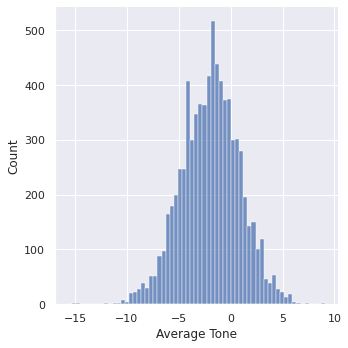

In [36]:
sns.set()
ax = sns.displot(df.Avg_tone)
plt.xlabel("Average Tone")
plt.savefig("../images/tone_dist.png")

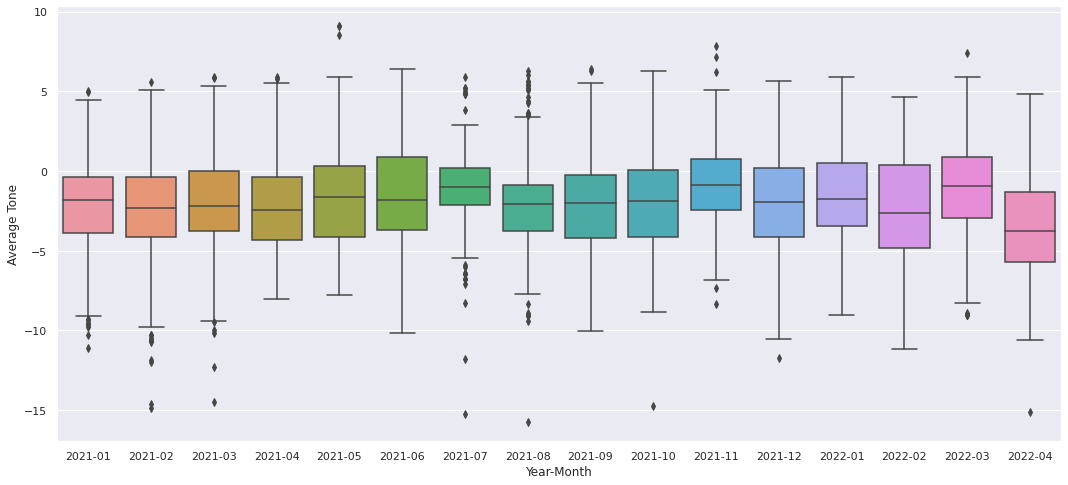

In [40]:
sns.set()
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(x="month_year", y="Avg_tone", data=df.sort_values(by="month_year"), ax = ax)
plt.xlabel("Year-Month")
plt.ylabel("Average Tone")
plt.savefig("../images/tone_boxplots.png")

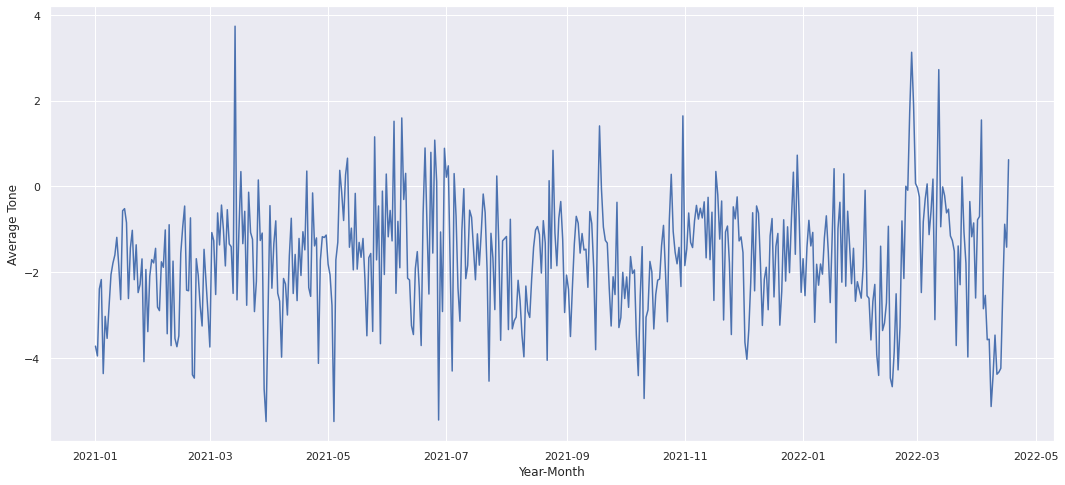

In [44]:
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=grouped_date.date, y=grouped_date.Avg_tone, ax = ax)
plt.xlabel("Year-Month")
plt.ylabel("Average Tone")
plt.savefig("../images/tone_time.png")

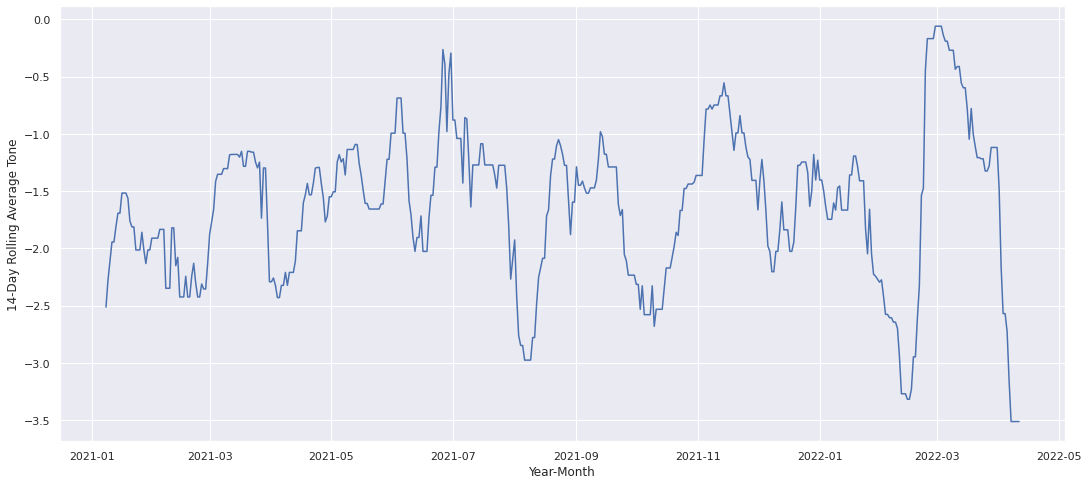

In [45]:
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=df_shifted.date, y=df_shifted.rolling_avg_tone)
plt.xlabel("Year-Month")
plt.ylabel("14-Day Rolling Average Tone")
plt.savefig("../images/tone_time_rolling.png")


# Compare Sentiment for Two Presidents

In [47]:
# create dataframes for the two presidents
# we check for the presidents' names in the "Persons" column

lungu_df = df[df['Persons'].str.contains("edgar lungu|president lungu", regex=True, na = False) & (df['Persons'].str.contains("hakainde hichilema|hh|president hichilema", regex=True, na = False)  == False)]
hh_df = df[df['Persons'].str.contains("hakainde hichilema|hh|president hichilema", regex=True, na = False) & (df['Persons'].str.contains("edgar lungu|president lungu", regex=True, na = False) == False)]

In [48]:
lungu_df.Avg_tone.describe()

count    275.000000
mean      -2.234931
std        2.332609
min      -11.783439
25%       -3.425246
50%       -1.720841
75%       -1.125704
max        6.018519
Name: Avg_tone, dtype: float64

In [49]:
hh_df.Avg_tone.describe()

count    315.000000
mean      -1.923895
std        2.778922
min       -9.009009
25%       -3.910252
50%       -2.281369
75%        0.185720
max        5.643739
Name: Avg_tone, dtype: float64

In [50]:
lungu_tones =  pd.DataFrame({"president": "Edgar Lungu", "Avg_tone": lungu_df.Avg_tone})
hh_tones = pd.DataFrame({"president": "Hakainde Hichilema", "Avg_tone": hh_df.Avg_tone})

combined = pd.concat([lungu_tones,hh_tones], axis=0)

combined.head()

,president,Avg_tone
3919,Edgar Lungu,-4.193548
3924,Edgar Lungu,6.018519
3929,Edgar Lungu,-2.189781
3934,Edgar Lungu,-3.389831
3935,Edgar Lungu,-3.280840


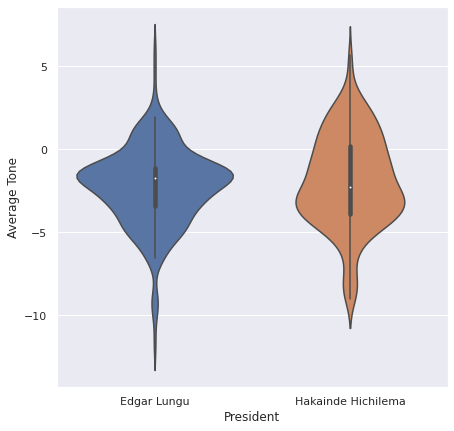

In [219]:
fig, ax = plt.subplots(figsize=(7,7))
sns.violinplot(x="president", y="Avg_tone", data = combined, ax = ax)
plt.xlabel("President")
plt.ylabel("Average Tone")
plt.savefig("../images/tone_violin_presidents.png")

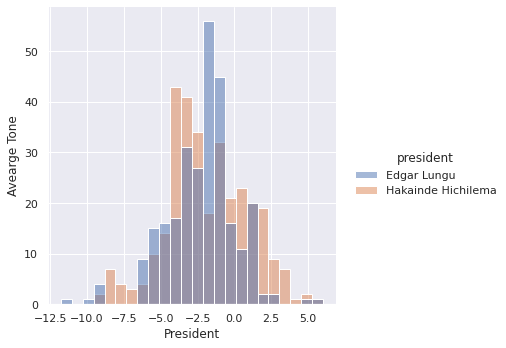

In [218]:
sns.displot(hue="president", x="Avg_tone", data = combined, ax = ax)
plt.xlabel("President")
plt.ylabel("Average Tone")
plt.savefig("../images/tone_dist_presidents.png")

# Outlier flagging on the daily tone

In [55]:
grouped_date.head()

,date,Avg_tone,rolling_avg_tone
0,2021-01-01,-3.723040,NaN
1,2021-01-02,-3.951555,NaN
2,2021-01-03,-2.388748,NaN
3,2021-01-04,-2.171266,NaN
4,2021-01-05,-4.362609,NaN


In [210]:
# fit and predict using isolation forest
# Tune contamination until the outliers make sense visually

clf = IsolationForest(contamination=0.024, random_state=0)
clf.fit(grouped_date[["Avg_tone"]] )
pred = clf.predict(grouped_date[["Avg_tone"]])

In [211]:
grouped_date["outlier"] = pd.Series(pred)
grouped_date.head()

,date,Avg_tone,rolling_avg_tone,outlier
0,2021-01-01,-3.723040,NaN,1
1,2021-01-02,-3.951555,NaN,1
2,2021-01-03,-2.388748,NaN,1
3,2021-01-04,-2.171266,NaN,1
4,2021-01-05,-4.362609,NaN,1


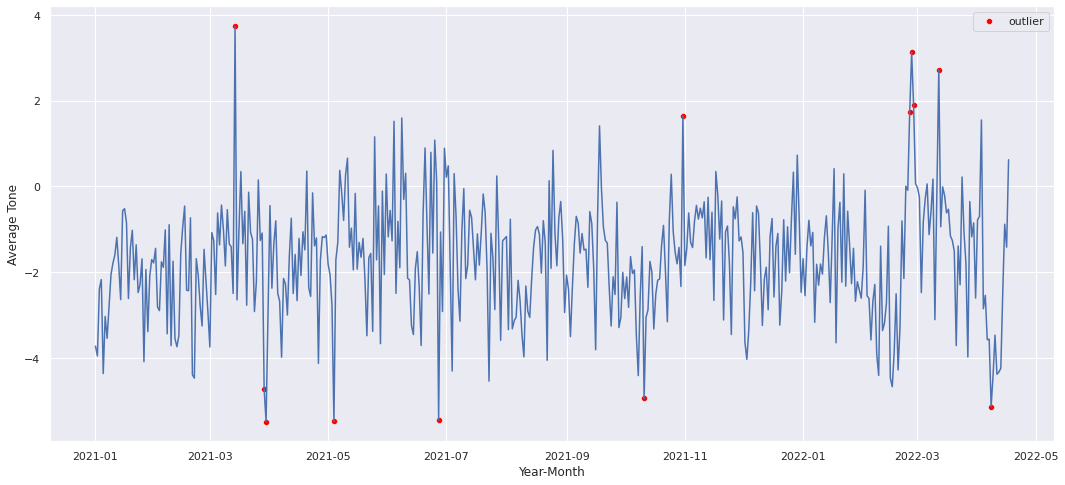

In [221]:
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x=grouped_date.date, y=grouped_date.Avg_tone ,ax = ax)
sns.scatterplot(data = grouped_date[grouped_date["outlier"]== -1],x="date", y="Avg_tone" , sizes = 200,ax = ax, label = "outlier", color = "red")
plt.xlabel("Year-Month")
plt.ylabel("Average Tone")
plt.savefig("../images/outlier_detection.png")

# Topic Modelling on Qoutations
Can be used as signals for time-series modelling

In [120]:
# filter where we have quotations

df_quotes = df[df.Quotations.notnull()]
df_quotes.head()

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year
20599,Zambia,20210727234500-1452,259|235||Our political leaders have suddenly d...,"-6.40478223740393,1.3663535439795,7.7711357813...",pat utomi;akinwunmi adesina;ayo oyoze baje;olu...,"BAN,6161;ECON_ELECTRICALGENERATION,2940;EDUCAT...",2021-07-27,-6.404782,9.137489,2021-07
20601,Zambia,20210728040000-663,281|235||Our political leaders have suddenly d...,"-6.45994832041344,1.37812230835487,7.838070628...",pat utomi;akinwunmi adesina;ayo oyoze baje;olu...,"BAN,6143;ECON_ELECTRICALGENERATION,2940;EDUCAT...",2021-07-28,-6.459948,9.216193,2021-07
20603,Zambian,20220210070000-694,963|26||premium of good leadership#4560|215||S...,"-3.3210332103321,4.15129151291513,7.4723247232...",aloysius uche ordu;hakainde hichilema;ede ijja...,"HEALTH_VACCINATION,401;HEALTH_VACCINATION,3220...",2022-02-10,-3.321033,11.623616,2022-02
20604,Zambia,20210322181500-2050,505|33||We are going UP UP UP UP UP UP UP#654|...,"-1.78335535006605,2.11360634081902,3.896961690...",astra zeneca;joe biden,"ARMEDCONFLICT,8192;EPU_CATS_NATIONAL_SECURITY,...",2021-03-22,-1.783355,6.010568,2021-03
20605,Zambia,20220124140000-187,4130|27||human rights-based recovery#10371|55|...,"-0.328715660953276,3.28246067151914,3.61117633...",agence fran;john campbell;tangi sala;joe biden...,"TAX_AIDGROUPS_INTERNATIONAL_CRISIS_GROUP,11098...",2022-01-24,-0.328716,6.893637,2022-01


In [146]:
df_topic = df_quotes[df_quotes.Persons.str.contains("hh|president lungu|hichilema|hakainde|edgar lungu", na = False)]
df_topic.sort_values(by="date", ascending= True)

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year
23398,Zambians,20210107021500-737,4501|71||activate your troops and deal with no...,"-2.56578947368421,4.29824561403509,6.864035087...",chama fumba;sean tembo;judith kabemba;maiko zu...,"RURAL,12489;RURAL,17241;RURAL,19570;TAX_FNCACT...",2021-01-07,-2.565789,11.162281,2021-01
21865,Zambia,20210119143000-1174,2271|29||mining investors who cry foul,"-1.45530145530146,1.87110187110187,3.326403326...",richard musukwa;edgar lungu,"GENERAL_GOVERNMENT,403;GENERAL_GOVERNMENT,1142...",2021-01-19,-1.455301,5.197505,2021-01
21876,Zambia,20210119151500-540,2273|29||mining investors who cry foul,"-1.45530145530146,1.87110187110187,3.326403326...",richard musukwa;edgar lungu,"GENERAL_GOVERNMENT,403;GENERAL_GOVERNMENT,1142...",2021-01-19,-1.455301,5.197505,2021-01
21852,Zambia,20210119213000-78,2025|29||mining investors who cry foul,"-1.12866817155756,2.03160270880361,3.160270880...",richard musukwa;edgar lungu,"GENERAL_GOVERNMENT,403;GENERAL_GOVERNMENT,1142...",2021-01-19,-1.128668,5.191874,2021-01
21616,Zambia,20210119170000-1176,1185|28||I can work with this country,"-2.95275590551181,1.37795275590551,4.330708661...",richard musukwa;edgar lungu;taonga clifford mi...,ECON_DEVELOPMENTORGS_INTERNATIONAL_MONETARY_FU...,2021-01-19,-2.952756,5.708661,2021-01
...,...,...,...,...,...,...,...,...,...,...
20806,Zambia,20220322024500-19,918|41||has more responsibility and opportunit...,"-2.5,1.84210526315789,4.34210526315789,6.18421...",ismail omar guelleh;thongloun sisoulith;mark s...,ECON_DEVELOPMENTORGS_INTERNATIONAL_MONETARY_FU...,2022-03-22,-2.500000,6.184211,2022-03
20809,Zambia,20220323021500-820,918|41||has more responsibility and opportunit...,"-2.5,1.84210526315789,4.34210526315789,6.18421...",ismail omar guelleh;thongloun sisoulith;mark s...,ECON_DEVELOPMENTORGS_INTERNATIONAL_MONETARY_FU...,2022-03-23,-2.500000,6.184211,2022-03
24187,Zambia,20220405113000-1263,751|35||in his interest to serve the public#21...,"-1.33729569093611,2.22882615156018,3.566121842...",sean tembo;al jazeera hichilema;uhuru kenyatta...,"TAX_FNCACT_CANDIDATES,3421;GENERAL_GOVERNMENT,...",2022-04-05,-1.337296,5.794948,2022-04
24176,Zambia,20220405103000-1171,317|35||in his interest to serve the public#17...,"-1.52027027027027,2.53378378378378,4.054054054...",sean tembo;uhuru kenyatta;hakainde hichilema;c...,"TAX_FNCACT_CANDIDATES,3040;GENERAL_GOVERNMENT,...",2022-04-05,-1.520270,6.587838,2022-04


In [147]:
# Function to clean the Quotations -- mostly clean except for numbers, | and # and punctuations

df_topic.Quotations.iloc[200]

'21433|48||which takes us closer to the debt free milestone#21858|100||to achieve upper end of 2021 Kounrad production guidance and lower end of Sasa production guidance#22016|109||between 23 , 000 tonnes and 25 , 000 tonnes for zinc and between 30 , 000 tonnes and 32 , 000 tonnes for lead#22542|360||We have advanced our Cut and Fill Project x2026 ; xA0 ; which is on track and on budget for commissioning in the last quarter of next year. During the period , development of the new Central Decline has commenced , all major components for the Paste Backfill Plant were ordered and plans for the Dry Stack Tailings part of the project are also advancing#24691|114||Placing Shares , assuming full take-up , will represent approximately 7 7 % of the Enlarged Issued Share Capital#25572|181||entered into various joint venture agreements to secure rights to process over 300mt of copper and cobalt containing tailings in Zambia x2026 ; located in three central locations#25822|156||Southern Refinery S

In [140]:
def clean(text): 
    # cleans the text using regex library
    # input: text => Strings 
    # returns: text => cleaned Strings
      
    text = str(text).lower()
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z A-Z]', ' ',text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'@[A-Za-z0–9]+', '', text) 
    text = re.sub(r' +', ' ', text)
    return text

In [151]:
df_topic["clean_quotations"] = df_topic["Quotations"].copy().apply(lambda x: clean(x))
df_topic.head()

/tmp/ipykernel_11039/2854731858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic["clean_quotations"] = df_topic["Quotations"].copy().apply(lambda x: clean(x))


,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year,clean_quotations
20603,Zambian,20220210070000-694,963|26||premium of good leadership#4560|215||S...,"-3.3210332103321,4.15129151291513,7.4723247232...",aloysius uche ordu;hakainde hichilema;ede ijja...,"HEALTH_VACCINATION,401;HEALTH_VACCINATION,3220...",2022-02-10,-3.321033,11.623616,2022-02,premium good leadership such inequality not s...
20606,Zambians,20210927110000-1033,1103|40||Africans are given to stealing electi...,"-1.68155543878087,3.46820809248555,5.149763531...",hakainde hechelema;adlai stevenson;yoweri muse...,"DELAY,11608;TAX_FNCACT_CANDIDATES,9721;CRISISL...",2021-09-27,-1.681555,8.617972,2021-09,africans are given stealing elections preside...
20619,Zambians,20210906124500-55,1103|40||Africans are given to stealing electi...,"-1.68155543878087,3.46820809248555,5.149763531...",hakainde hechelema;adlai stevenson;yoweri muse...,"DELAY,11608;TAX_FNCACT_CANDIDATES,9721;CRISISL...",2021-09-06,-1.681555,8.617972,2021-09,africans are given stealing elections preside...
20675,Zambia,20211125234500-883,"925|107||unequal campaign conditions , restric...","-3.38218714768884,3.94588500563698,7.328072153...",edgar lungu;maurice jangulo;robert besseling;h...,"WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,2...",2021-11-25,-3.382187,11.273957,2021-11,unequal campaign conditions restrictions free...
20690,Zambia,20211216111500-434,"925|107||unequal campaign conditions , restric...","-3.38218714768884,3.94588500563698,7.328072153...",edgar lungu;maurice jangulo;robert besseling;h...,"WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,2...",2021-12-16,-3.382187,11.273957,2021-12,unequal campaign conditions restrictions free...


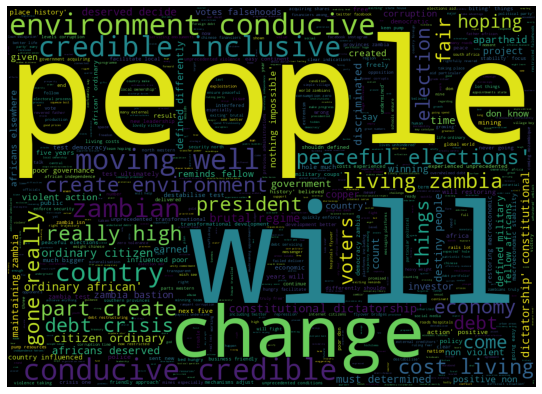

In [156]:
customStopwords=list(STOPWORDS)


wordcloudimage=WordCloud(max_words=2400,
                         max_font_size=500,
                         font_step=2,
                         stopwords=customStopwords,
                         background_color='black',
                         width=1000,
                         height=720).generate(str(df_topic['clean_quotations'].values))                          
 
plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

In [157]:

# Remove stop words
stop_words = set(stopwords.words("english"))
df_topic["clean_quotations"] = df_topic["clean_quotations"].apply(lambda x : " ".join([w.lower() for w in x.split() if w not in stop_words and len(w) > 3]))
df_topic.head()

/tmp/ipykernel_11039/2843860148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic["clean_quotations"] = df_topic["clean_quotations"].apply(lambda x : " ".join([w.lower() for w in x.split() if w not in stop_words and len(w) > 3]))


,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year,clean_quotations
20603,Zambian,20220210070000-694,963|26||premium of good leadership#4560|215||S...,"-3.3210332103321,4.15129151291513,7.4723247232...",aloysius uche ordu;hakainde hichilema;ede ijja...,"HEALTH_VACCINATION,401;HEALTH_VACCINATION,3220...",2022-02-10,-3.321033,11.623616,2022-02,premium good leadership inequality simply unju...
20606,Zambians,20210927110000-1033,1103|40||Africans are given to stealing electi...,"-1.68155543878087,3.46820809248555,5.149763531...",hakainde hechelema;adlai stevenson;yoweri muse...,"DELAY,11608;TAX_FNCACT_CANDIDATES,9721;CRISISL...",2021-09-27,-1.681555,8.617972,2021-09,africans given stealing elections presidential...
20619,Zambians,20210906124500-55,1103|40||Africans are given to stealing electi...,"-1.68155543878087,3.46820809248555,5.149763531...",hakainde hechelema;adlai stevenson;yoweri muse...,"DELAY,11608;TAX_FNCACT_CANDIDATES,9721;CRISISL...",2021-09-06,-1.681555,8.617972,2021-09,africans given stealing elections presidential...
20675,Zambia,20211125234500-883,"925|107||unequal campaign conditions , restric...","-3.38218714768884,3.94588500563698,7.328072153...",edgar lungu;maurice jangulo;robert besseling;h...,"WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,2...",2021-11-25,-3.382187,11.273957,2021-11,unequal campaign conditions restrictions freed...
20690,Zambia,20211216111500-434,"925|107||unequal campaign conditions , restric...","-3.38218714768884,3.94588500563698,7.328072153...",edgar lungu;maurice jangulo;robert besseling;h...,"WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,2...",2021-12-16,-3.382187,11.273957,2021-12,unequal campaign conditions restrictions freed...


In [186]:
#vectorize data

vectorizer = TfidfVectorizer(ngram_range=(2,3))
data_vectorized = vectorizer.fit_transform(df_topic.clean_quotations)

## Grid Search to find the Optimal model

In [181]:
# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 6], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 3, 4, 5, 6]})

In [183]:
model.best_params_

{'learning_decay': 0.5, 'n_components': 2}

In [188]:
# LDA Implementation

number_of_topics = 2
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0, learning_decay=0.5)
model.fit(data_vectorized)

LatentDirichletAllocation(learning_decay=0.5, n_components=2, random_state=0)

### View top words in the respective topics

In [199]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=model, n_words=20):
    """
    function to show table of top words in the topic model
    paramaters
    ----------
    vectorizer: vector obtained used vectorizer
    lda_model: topic model instance
    n_words: number of words to show in table

    returns:
    topic_kewords: list of words for each topic
    """
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,constitutional dictatorship,brutal regime,brutal regime exiting,regime exiting,positive violent,positive violent action,violent action,much bigger expected,bigger expected,hole much bigger,hole much,much bigger,reminds fellow,africans elsewhere nothing,elsewhere nothing impossible
Topic 1,interfered undermined,citizen ordinary,ordinary citizen ordinary,ordinary african,ordinary citizen,citizen ordinary african,moving well country,things moving,moving well,well country,things moving well,peaceful elections,credible inclusive peaceful,inclusive peaceful elections,conducive credible


### Visualize the topics using pyLDAvis

In [195]:
%%capture
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, data_vectorized, vectorizer, mds='tsne')


In [198]:
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1     -60.312317  141.369629       1        1  58.214118
0      60.312561 -141.369141       2        1  41.785882, topic_info=                             Term      Freq     Total Category  logprob  \
572   constitutional dictatorship  3.000000  3.000000  Default  30.0000   
346                 brutal regime  1.000000  1.000000  Default  29.0000   
347         brutal regime exiting  1.000000  1.000000  Default  28.0000   
2686               regime exiting  1.000000  1.000000  Default  27.0000   
2411             positive violent  1.000000  1.000000  Default  26.0000   
...                           ...       ...       ...      ...      ...   
2057         much bigger expected  0.782950  0.986588   Topic2  -6.6368   
305               bigger expected  0.782949  0.986588   Topic2  -6.6368   
1534             hole much bigger  0.782948  0.986588   Topic2  -6.6368   
1533                    hole much  0.782948  0.986589   Topic2  -6.6368   
2056                  much bigger  0.782940  0.986591   Topic2  -6.6368   

      loglift  
572   30.0000  
346   29.0000  
347   28.0000  
2686  27.0000  
2411  26.0000  
...       ...  
2057   0.6414  
305    0.6414  
1534   0.6414  
1533   0.6414  
2056   0.6414  

[97 rows x 6 columns], token_table=      Topic      Freq                        Term
term                                             
119       2  1.071302          africans elsewhere
120       2  1.071302  africans elsewhere nothing
305       2  1.013594             bigger expected
346       2  1.112872               brutal regime
347       2  1.112872       brutal regime exiting
...     ...       ...                         ...
3543      1  0.539198                well country
3544      1  0.968385     well country influenced
3666      1  0.955699                 zambia gone
3667      1  0.955699          zambia gone really
3672      2  1.081955               zambia lovely

[67 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## Check Average Tone for each of the topics Obtained

In [200]:
df_topic.head()

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year,clean_quotations
20603,Zambian,20220210070000-694,963|26||premium of good leadership#4560|215||S...,"-3.3210332103321,4.15129151291513,7.4723247232...",aloysius uche ordu;hakainde hichilema;ede ijja...,"HEALTH_VACCINATION,401;HEALTH_VACCINATION,3220...",2022-02-10,-3.321033,11.623616,2022-02,premium good leadership inequality simply unju...
20606,Zambians,20210927110000-1033,1103|40||Africans are given to stealing electi...,"-1.68155543878087,3.46820809248555,5.149763531...",hakainde hechelema;adlai stevenson;yoweri muse...,"DELAY,11608;TAX_FNCACT_CANDIDATES,9721;CRISISL...",2021-09-27,-1.681555,8.617972,2021-09,africans given stealing elections presidential...
20619,Zambians,20210906124500-55,1103|40||Africans are given to stealing electi...,"-1.68155543878087,3.46820809248555,5.149763531...",hakainde hechelema;adlai stevenson;yoweri muse...,"DELAY,11608;TAX_FNCACT_CANDIDATES,9721;CRISISL...",2021-09-06,-1.681555,8.617972,2021-09,africans given stealing elections presidential...
20675,Zambia,20211125234500-883,"925|107||unequal campaign conditions , restric...","-3.38218714768884,3.94588500563698,7.328072153...",edgar lungu;maurice jangulo;robert besseling;h...,"WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,2...",2021-11-25,-3.382187,11.273957,2021-11,unequal campaign conditions restrictions freed...
20690,Zambia,20211216111500-434,"925|107||unequal campaign conditions , restric...","-3.38218714768884,3.94588500563698,7.328072153...",edgar lungu;maurice jangulo;robert besseling;h...,"WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,2...",2021-12-16,-3.382187,11.273957,2021-12,unequal campaign conditions restrictions freed...


In [202]:
def get_inference(model, vectorizer, topics, text, threshold):
    """
    runs inference on text input
    paramaters
    ----------
    model: loaded model to use to transform the input
    vectorizer: instance of the vectorizer e.g TfidfVectorizer(ngram_range=(2, 3))
    topics: the list of topics in the model
    text: input string to be classified
    threshold: float of threshold to use to output a topic based on the score
    returns
    -------
    tuple => top score
    
    """
    v_text = vectorizer.transform([text])
    score = model.transform(v_text)

    labels = set()
    for i in range(len(score[0])):
        if score[0][i] > threshold:
            labels.add(topics[i])
    if not labels:
        return 'None', -1, set()

    return topics[np.argmax(score)]

In [214]:
topics = [0,1]
df_topic["topic"] = df_topic.clean_quotations.apply(lambda x: get_inference(model,vectorizer,topics,np.str_(x),0))
df_topic.head()

,location,GKGRECORDID,Quotations,V2Tone,Persons,V2Themes,date,Avg_tone,polarity,month_year,clean_quotations,topic
20603,Zambian,20220210070000-694,963|26||premium of good leadership#4560|215||S...,"-3.3210332103321,4.15129151291513,7.4723247232...",aloysius uche ordu;hakainde hichilema;ede ijja...,"HEALTH_VACCINATION,401;HEALTH_VACCINATION,3220...",2022-02-10,-3.321033,11.623616,2022-02,premium good leadership inequality simply unju...,0
20606,Zambians,20210927110000-1033,1103|40||Africans are given to stealing electi...,"-1.68155543878087,3.46820809248555,5.149763531...",hakainde hechelema;adlai stevenson;yoweri muse...,"DELAY,11608;TAX_FNCACT_CANDIDATES,9721;CRISISL...",2021-09-27,-1.681555,8.617972,2021-09,africans given stealing elections presidential...,0
20619,Zambians,20210906124500-55,1103|40||Africans are given to stealing electi...,"-1.68155543878087,3.46820809248555,5.149763531...",hakainde hechelema;adlai stevenson;yoweri muse...,"DELAY,11608;TAX_FNCACT_CANDIDATES,9721;CRISISL...",2021-09-06,-1.681555,8.617972,2021-09,africans given stealing elections presidential...,0
20675,Zambia,20211125234500-883,"925|107||unequal campaign conditions , restric...","-3.38218714768884,3.94588500563698,7.328072153...",edgar lungu;maurice jangulo;robert besseling;h...,"WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,2...",2021-11-25,-3.382187,11.273957,2021-11,unequal campaign conditions restrictions freed...,1
20690,Zambia,20211216111500-434,"925|107||unequal campaign conditions , restric...","-3.38218714768884,3.94588500563698,7.328072153...",edgar lungu;maurice jangulo;robert besseling;h...,"WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT,2...",2021-12-16,-3.382187,11.273957,2021-12,unequal campaign conditions restrictions freed...,1


Text(0, 0.5, 'Avearge Tone')

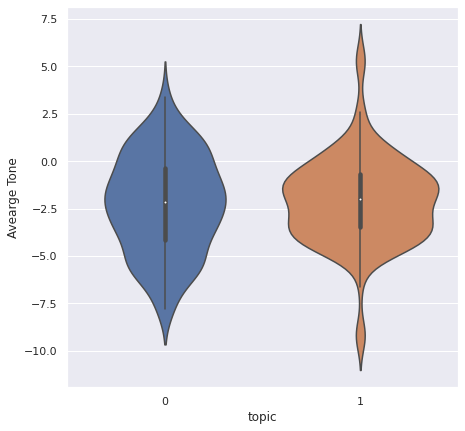

In [208]:
fig, ax = plt.subplots(figsize=(7,7))
sns.violinplot(x="topic", y="Avg_tone", data = df_topic, ax = ax)
plt.xlabel("topic")
plt.ylabel("Avearge Tone")

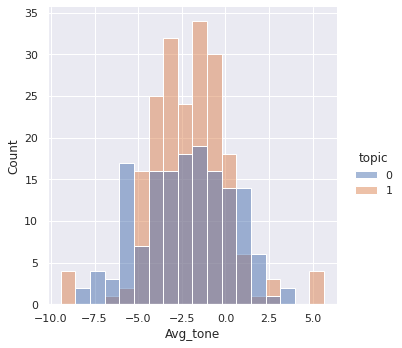

In [213]:
sns.displot(data =df_topic, x = "Avg_tone", hue = "topic" )